# Exploratory Data Analysis (Formatted Zone)
Complex Seasonality Analysis

In [410]:
import datetime

from database_settings import postgres_utilities
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from exploratory_data_analysis.formatted import utilities

## Get the time series


In [411]:
# Establish the connection with the Persistent Zone
engine = postgres_utilities.engine()
# Filters
net_weight_threshold = 100
value_usd_threshold = 200
headings_count_threshold = 100
year_threshold = 2017
# Get all the data filtered
df = pd.DataFrame(postgres_utilities.run_query_file(engine,
                                           './queries/heading_data.sql',
                                           params={'year_threshold': year_threshold,
                                                   'headings_count_threshold': headings_count_threshold,
                                                   'value_usd_threshold': value_usd_threshold,
                                                   'net_weight_threshold': net_weight_threshold}))

Connected to Formatted Zone successfully!


In [412]:
# Select a random heading (optionally, select a exporter)
heading, description, exporter = df.sample()[['heading','description', 'exporter_id']].iloc[0]
print('Heading: {}, Description: {}'.format(heading,description))
heading_data = df[(df['heading']==heading)].copy()

Heading: 0804400000, Description: Aguacates (paltas) frescos o secos


In [413]:
# Generate the time granularities
start_date = heading_data['boarding_date'].min()
end_date = heading_data['boarding_date'].max()

time_granularities = utilities.generate_time_granularities(start_date,end_date)

# import datetime
#
# start_date = datetime.date(2017,1,1)
# end_date = datetime.date(2023,4,29)
#
#
# time_granularities = pd.date_range(start=start_date, end=end_date, freq='D')
# time_granularities = pd.DataFrame(index=time_granularities)
time_granularities

,year,semester_in_year,quarter_in_year,month_in_year,month_in_semester,month_in_quarter,quarter_in_semester,day_in_year,day_in_semester,day_in_quarter,day_in_month,day_in_week,week_in_year,week_in_semester,week_in_quarter,week_in_month
2017-01-06,2017,1,1,1,1,1,1,6,6,6,6,5,1,1,1,1
2017-01-07,2017,1,1,1,1,1,1,7,7,7,7,6,1,1,1,1
2017-01-08,2017,1,1,1,1,1,1,8,8,8,8,7,1,1,1,1
2017-01-09,2017,1,1,1,1,1,1,9,9,9,9,1,2,2,2,2
2017-01-10,2017,1,1,1,1,1,1,10,10,10,10,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-16,2023,1,2,4,4,1,2,106,106,16,16,7,15,15,2,2
2023-04-17,2023,1,2,4,4,1,2,107,107,17,17,1,16,16,3,3
2023-04-18,2023,1,2,4,4,1,2,108,108,18,18,2,16,16,3,3
2023-04-19,2023,1,2,4,4,1,2,109,109,19,19,3,16,16,3,3


### Daily kilogram's price time series

In [414]:
# usd/kg time series
heading_data['usd_kg'] = heading_data['value_usd']/heading_data['net_weight']
heading_data['usd_kg'] = heading_data['usd_kg'].astype(float)
heading_data['usd_kg'] = heading_data['usd_kg'].round(3)
# Group by boarding_date
usd_kg = heading_data[['boarding_date','usd_kg']].groupby(by=['boarding_date']).mean().round(3)
# Impute missing dates assigning the usd_kg of the day before
usd_kg.index = pd.to_datetime(usd_kg.index)
usd_kg = usd_kg.resample('D').ffill()
# Add the time granularities
usd_kg = pd.concat([usd_kg, time_granularities], axis=1)
usd_kg

,usd_kg,year,semester_in_year,quarter_in_year,month_in_year,month_in_semester,month_in_quarter,quarter_in_semester,day_in_year,day_in_semester,day_in_quarter,day_in_month,day_in_week,week_in_year,week_in_semester,week_in_quarter,week_in_month
2017-01-06,2.076,2017,1,1,1,1,1,1,6,6,6,6,5,1,1,1,1
2017-01-07,1.905,2017,1,1,1,1,1,1,7,7,7,7,6,1,1,1,1
2017-01-08,1.905,2017,1,1,1,1,1,1,8,8,8,8,7,1,1,1,1
2017-01-09,1.905,2017,1,1,1,1,1,1,9,9,9,9,1,2,2,2,2
2017-01-10,1.905,2017,1,1,1,1,1,1,10,10,10,10,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-16,1.675,2023,1,2,4,4,1,2,106,106,16,16,7,15,15,2,2
2023-04-17,2.084,2023,1,2,4,4,1,2,107,107,17,17,1,16,16,3,3
2023-04-18,2.092,2023,1,2,4,4,1,2,108,108,18,18,2,16,16,3,3
2023-04-19,2.092,2023,1,2,4,4,1,2,109,109,19,19,3,16,16,3,3


### Daily total (net) weight exporter time series

In [415]:
# total net weight time series
# Group by boarding_date
net_weight = heading_data[['boarding_date','net_weight']].groupby(by=['boarding_date']).sum().round(3)
# Impute missing dates assigning 0 kg for days without shipments
net_weight.index = pd.to_datetime(net_weight.index)
net_weight = net_weight.resample('D').asfreq()
net_weight.fillna(0.0, inplace=True)
# Convert numerical columns to float
net_weight = net_weight.astype({'net_weight': 'float'})
# Add the time granularities
net_weight = pd.concat([net_weight, time_granularities], axis=1)
net_weight

,net_weight,year,semester_in_year,quarter_in_year,month_in_year,month_in_semester,month_in_quarter,quarter_in_semester,day_in_year,day_in_semester,day_in_quarter,day_in_month,day_in_week,week_in_year,week_in_semester,week_in_quarter,week_in_month
2017-01-06,42528.000,2017,1,1,1,1,1,1,6,6,6,6,5,1,1,1,1
2017-01-07,63552.000,2017,1,1,1,1,1,1,7,7,7,7,6,1,1,1,1
2017-01-08,0.000,2017,1,1,1,1,1,1,8,8,8,8,7,1,1,1,1
2017-01-09,0.000,2017,1,1,1,1,1,1,9,9,9,9,1,2,2,2,2
2017-01-10,0.000,2017,1,1,1,1,1,1,10,10,10,10,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-16,600315.908,2023,1,2,4,4,1,2,106,106,16,16,7,15,15,2,2
2023-04-17,350980.360,2023,1,2,4,4,1,2,107,107,17,17,1,16,16,3,3
2023-04-18,164508.000,2023,1,2,4,4,1,2,108,108,18,18,2,16,16,3,3
2023-04-19,0.000,2023,1,2,4,4,1,2,109,109,19,19,3,16,16,3,3


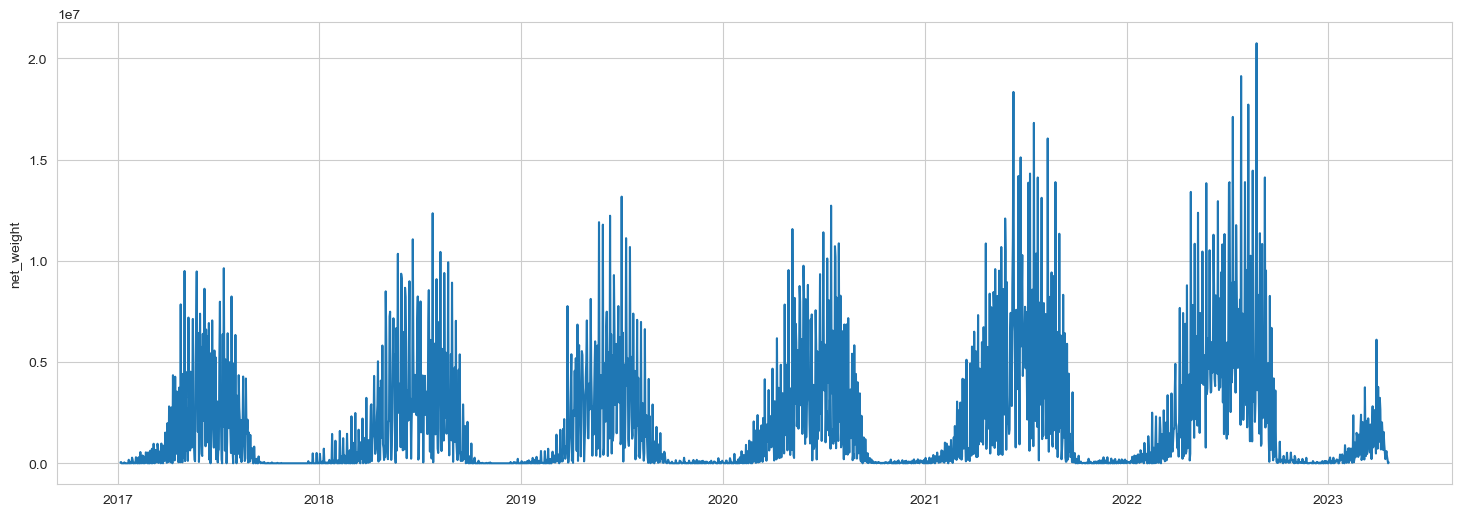

In [416]:
# Plot time series
plt.figure(figsize=(18,6))
sns.lineplot(x=net_weight.index, y="net_weight", data=net_weight)
plt.show()

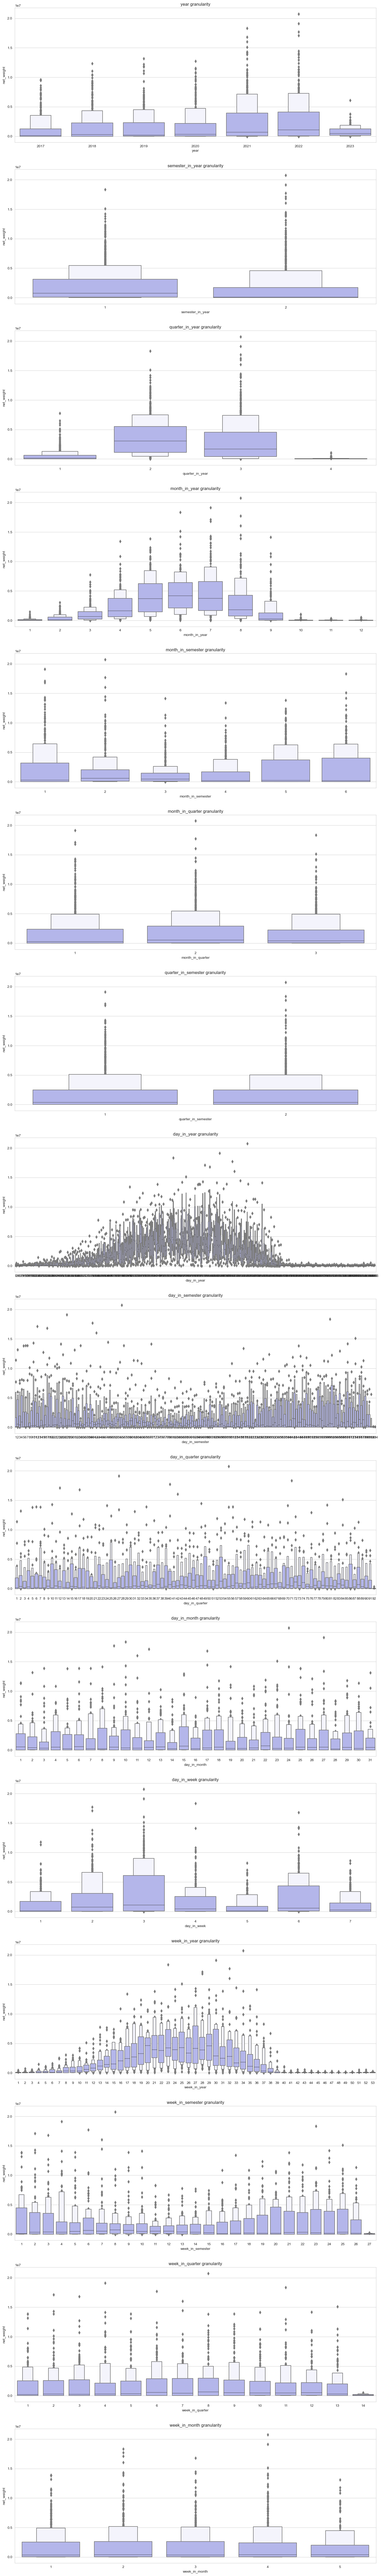

In [417]:
# Granularity plots

# Provide the data
data = net_weight

# Indicate the target column
target_column = 'net_weight'

# Set the granularities to plot
granularities = ['year',
                 'semester_in_year',
                 'quarter_in_year',
                 'month_in_year',
                 'month_in_semester',
                 'month_in_quarter',
                 'quarter_in_semester',
                 'day_in_year',
                 'day_in_semester',
                 'day_in_quarter',
                 'day_in_month',
                 'day_in_week',
                 'week_in_year',
                 'week_in_semester',
                 'week_in_quarter',
                 'week_in_month'
                 ]

# Create the subplots
fig, axes = plt.subplots(nrows=len(granularities),figsize=(18, len(granularities)*8))
# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate over each column and create the corresponding subplot
for i, column in enumerate(granularities):
    sns.boxenplot(ax=axes[i],
                data=data,
                x=column,
                y=target_column,
                order=[str(i) for i in data[column].astype(int).sort_values().unique()],
                k_depth=2,
                #showfliers = False,
                palette=['#abaef3'])
    axes[i].set_title(f"{column} granularity")

# Display the plot
plt.show()

In [418]:
from scipy.spatial.distance import jensenshannon
import numpy as np
from scipy import stats
from sklearn.preprocessing import quantile_transform
from scipy.stats import norm
import itertools
from tqdm.notebook import tqdm

def statistic(*samples):

    # Get the max and min observation among all the data
    all_observations = [observation for sample in samples for observation in sample]
    max_observation = max(all_observations)
    min_observation = min(all_observations)

    # Define the bins
    n_bins = 10
    bins = np.linspace(min_observation, max_observation, n_bins)

    # Create the probability vector for each sample
    probability_vectors = []
    for sample in samples:
        # take the observations of the respective sample
        observations = np.array(sample)
        # count the ocurrences in each bin
        freq_count, bin_edges = np.histogram(observations, bins=bins)
        # calculate the probability of each bin
        probability_vector = freq_count/len(observations)
        # append to the probability vectors list
        probability_vectors.append(probability_vector)

    # Get the Jensen-Shannon Distances from all pairs
    pairs = itertools.combinations(probability_vectors, 2)
    jensen_shanon_distances = []
    for pair in pairs:
        jsd = jensenshannon(pair[0], pair[1])
        jensen_shanon_distances.append(jsd)

    # Get the Jensen-Shannon Distances from consecutive samples (time wise speaking)
    # jensen_shanon_distances = []
    # for i in range(len(probability_vectors) - 1):
    #     jsd = jensenshannon(probability_vectors[i], probability_vectors[i+1], 2)
    #     jensen_shanon_distances.append(jsd)

    return max(jensen_shanon_distances)

In [434]:
# Distributions comparison
data = net_weight

# Choose the observations column
target = 'net_weight'
# Choose the time granularity to analyze
cyclic_granularity = 'week_in_month'

# Get the observations from each subset from the time granularity (sorted by label in ascending order)
samples = [data.loc[data[cyclic_granularity] == str(subset), target].values
           for subset in sorted(map(int, data[cyclic_granularity].unique()))]

# Remove samples with less than 2 observations (caused by leap years, from 2024 this won't be needed)
samples = [sample for sample in samples if len(sample) >= 2]

Statistic: 0.08124372517325398
p-value: 0.8801198801198801


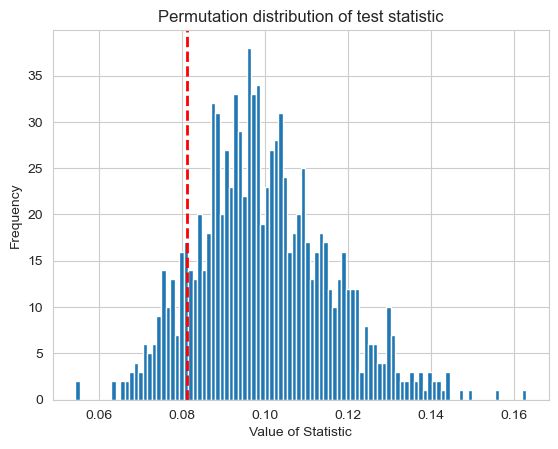

In [435]:
res = stats.permutation_test(samples, statistic, n_resamples=1000, alternative='greater')
print('Statistic: '+str(res.statistic))
print('p-value: '+str(res.pvalue))
# res.null_distribution
plt.hist(res.null_distribution, bins=100)
plt.title("Permutation distribution of test statistic")
plt.xlabel("Value of Statistic")
plt.ylabel("Frequency")
plt.axvline(res.statistic, color='red', linestyle='dashed', linewidth=2)
plt.show()

In [ ]:
# from scipy.spatial.distance import jensenshannon
# import numpy as np
# from scipy import stats
# from sklearn.preprocessing import quantile_transform
# from scipy.stats import norm
#
# def statistic(*samples):
#
#     # Create the probability vector for each sample
#     probability_vectors = []
#     for sample in samples:
#         # take the observations of the respective sample
#         observations = sample
#         # add a random and very small amount of noise in every observation (avoid having all values the same)
#         observations = observations + abs(np.random.normal(loc=0, scale=1e-4, size=len(observations)))
#         # sort the observations in ascending order and reshape
#         observations =  np.sort(observations).reshape(-1, 1)
#         # Data transformation: perform a Normal-Quantile Transformation
#         qnorm = quantile_transform(observations, output_distribution='normal', n_quantiles=len(observations))
#         # Distribution characterization:
#         # get the percentiles
#         percentiles = np.percentile(qnorm, np.linspace(0, 1, num=100)*100)
#         # get the percentiles probabilities
#         cumulative_probability = norm.cdf(percentiles) # This gives the cumulative probability
#         # Get the interpercentile probabilities
#         interpercentile_probabilities = np.insert(np.diff(cumulative_probability), 0, cumulative_probability[0]) # This give the interpercentile probability
#         # append to the probability vectors list
#         probability_vectors.append(interpercentile_probabilities)
#
#     # Get the Jensen-Shannon Distances from consecutive samples (time wise speaking)
#     jensen_shanon_distances = []
#     for i in range(len(probability_vectors) - 1):
#         jsd = jensenshannon(probability_vectors[i], probability_vectors[i+1], 2)
#         jensen_shanon_distances.append(jsd)
#
#     return max(jensen_shanon_distances)